In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import maxnorm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from keras import regularizers

## Creating the pixel data from images in file

In [2]:
DATADIR = "dataset-resized"

# All the categories you want your neural network to detect
CATEGORIES = ["cardboard", "glass", "metal", "paper", "plastic", "ewaste"]

In [3]:
IMG_SIZE = 50
training_data = []

def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizing the image to specified image size (50)
				training_data.append([new_array, class_num]) # add pixel color values array and category index to training data list
			except Exception as e:
				pass

In [4]:
create_training_data()

In [5]:
X = [] #features
y = [] #labels (index numbers 0-5 pertaining to waste category)

for features, label in training_data:
	X.append(features)
	y.append(label)

In [6]:
# scale pixel color values using MinMaxScaler
scaler = MinMaxScaler()
X = np.array(X).reshape(-1, IMG_SIZE * IMG_SIZE * 3)
X_scaled = scaler.fit_transform(X)

In [7]:
# adjust format of data by reshaping X and converting y to a numnpy array
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [8]:
len(y)

2709

In [9]:
X.shape

(2709, 50, 50, 3)

In [10]:
# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3000)

## Creating and training the model

In [11]:
def create_model(activation = 'relu'):
    # Building the model
    model = Sequential()
    # 3 convolutional layers
    model.add(Conv2D(32, (3, 3), input_shape = X_train.shape[1:], activation=activation, padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2,2))) #max pooling
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2,2))) #max pooling
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # 2 hidden layers
    model.add(Flatten())
    model.add(Dense(128, kernel_constraint=maxnorm(3)))
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(64, kernel_constraint=maxnorm(3)))
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # The output layer with 6 neurons, for 6 classes
    model.add(Dense(6))
    model.add(Activation("softmax"))

    # Compiling the model using some basic parameters
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    print(model.summary())
    return model

In [18]:
np.random.seed(21)
# Training the model, with 25 iterations using batch size of 32 and relu activation function
model = create_model()
early_stopping = EarlyStopping(patience=5) # using early stopping to reduce overfitting
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=25, 
                    batch_size=32, callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 64)       

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


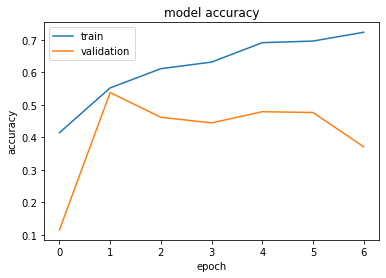

In [19]:
# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

## Hyperparameter tuning 

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
# Create a KerasClassifier
classifier = KerasClassifier(build_fn = create_model, verbose = 0)

# Define the parameters to try out
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64]}

In [15]:
random_search = RandomizedSearchCV(classifier, param_distributions = params, cv = KFold(5))
random_search_results = random_search.fit(X_train, y_train)

print("Best Score: ", random_search_results.best_score_, "and Best Params: ", random_search_results.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 64)       

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_20 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_20 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 25, 25, 64)       

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_35 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_35 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 25, 25, 64)       

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_50 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_50 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 25, 25, 64)      

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_65 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_65 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 25, 25, 64)      

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_80 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_80 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 25, 25, 64)      

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_95 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_95 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 25, 25, 64)      

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_110 (Dropout)        (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_110 (Bat (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_110 (Activation)  (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 25, 25, 64)      

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_125 (Dropout)        (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_125 (Bat (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_125 (Activation)  (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_126 (Dropout)        (None, 25, 25, 64)      

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_140 (Dropout)        (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_140 (Bat (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_140 (Activation)  (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_141 (Dropout)        (None, 25, 25, 64)      

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
dropout_155 (Dropout)        (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_155 (Bat (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_155 (Activation)  (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_156 (Dropout)        (None, 25, 25, 64)      

## Re-evaluating Model with the Best Parameter Set

In [12]:
# best params was 'batch_size' = 16 and 'activation' = 'relu' with best score of 0.4377
model = create_model(activation='relu')
early_stopping = EarlyStopping(patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=25, 
                    batch_size=16, callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)       

Saved model to disk
INFO:tensorflow:Assets written to: CNN.model/assets
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


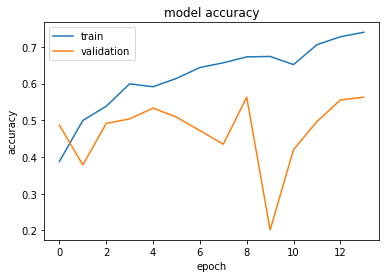

In [15]:
# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

## Testing the model with testing set

In [16]:
# Model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
#accuracy = 56.05%

Accuracy: 56.05%


## Predicting an image class

In [17]:
CATEGORIES = ["cardboard", "glass", "metal", "paper", "plastic", "ewaste"]
def prepare(file):
    IMG_SIZE = 50
    img_array = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
model = tf.keras.models.load_model("CNN.model")
image = r"dataset-resized/metal/metal100.jpg" #your image path
prediction = model.predict(prepare(image))
prediction = list(prediction[0])
print(CATEGORIES[prediction.index(max(prediction))])

metal


In [ ]:
#sources:
https://stackabuse.com/image-recognition-in-python-with-tensorflow-and-keras/
https://github.com/garythung/trashnet
https://datascience.stackexchange.com/questions/48390/how-do-i-build-an-image-dataset-for-cnn
https://towardsdatascience.com/all-the-steps-to-build-your-first-image-classifier-with-code-cf244b015799
https://onezero.blog/hyperparameter-tuning-of-keras-deep-learning-model-in-python/
https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd